<center>

# R для тервера и матстата
## Максимальное правдоподобие

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_4/M_MPlain_grande.png" height="200" width="350"> 





Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2019). Автор ноутбука - [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/R_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

-------------------------------


В прошлый раз мы с вами поговорили точечные оценки, их свойства и доверительные интервалы. Также мы немного вспомнили метод моментов, который помогает эти самые точечные оценки получать. Сегодня мы во всех подробностях обсудим другой метод получения точечных оценок, __метод максимального правдоподобия.__

Метод максимального правдоподобия — это основная лошадка современной статистики. Функция правдоподобия встречается абсолютно во всех областях от эконометрики и байесовской статистики до нейронных сетей и рекомендательных систем. Из-за этого очень важно как следует понять как она устроена. В этой тетрадке именно этим мы и займёмся. Итак, сегодня в программе: 

* Что такое метод максимального правдоподобия, вырабатываем интуицию 
* Решаем задачу про конфеты и смотрим на свойства оценок максимального правдоподобия 
* Из метода максимального правдоподобия на нас неожиданно выпрыгивает информация Фишера, разбираемся с тем почему эта штука называется информацией Фишера
* Решаем несколько задачек
* Строим тест отношения правдоподобий __(НЕ ПУТАТЬ С ЛЕММОЙ Неймана-Пирсона из ваших лекций, где тоже фигурировало отношение правдоподобий! Это разные вещи!)__

In [1]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

In [3]:
# В этом блоке написаны несколько функций, которые рисуют красивые картинки для проверки гипотез.
# Можно не обращать на них внимание :) 

# Область, которую надо будет закрасить на графике 
limitRange <- function(fun, min, max) {
    function(x) {
        y <- fun(x)
        y[x < min  |  x > max] <- NA
        return(y)
    }
}


# Эта страшная функция нужна для карсивых картинок для хи-квадрат распределения
chi_stat_picture <- function(chi_stat, n, alpha =0.05, alternative = 'two-sided'){
    # Опции для размеров графика
    options(repr.plot.width=6, repr.plot.height=3)
    
    # Какие области надо закрасить (зависит от алтиернативы)
    if(alternative == 'two-sided'){
        chi_crit1 <- qchisq(1-(alpha/2), df=n)
        chi_crit2 <- qchisq(alpha/2, df=n)
        dlimit_left  <- limitRange(function(x) dchisq(x, df=n), 0, chi_crit2) 
        dlimit_right <- limitRange(function(x) dchisq(x, df=n), chi_crit1, Inf) 
        }
    if(alternative == 'less'){
        chi_crit2 <- qchisq(alpha,df=n)
        dlimit_left  <- limitRange(function(x) dchisq(x, df=n), 0, chi_crit2)
        dlimit_right <- limitRange(function(x) dchisq(x, df=n), Inf, Inf)        
    }
    if(alternative == 'greater'){
        chi_crit1 <- qchisq(1 - alpha,df=n)
        dlimit_left  <- limitRange(function(x) dchisq(x, df=n), 0, 0)
        dlimit_right <- limitRange(function(x) dchisq(x, df=n), chi_crit1, Inf)
        }        
      
    # Основная картинка
    p <- ggplot(data.frame(x=c(0, qchisq(1-(alpha/2), df=n) + 2)), aes(x = x))+
       stat_function(fun=dchisq, args = list(df=n)) +  # вся функция 
       stat_function(fun=dlimit_left, geom="area",  fill="blue", alpha=0.2) +
       stat_function(fun=dlimit_right, geom="area", fill="blue", alpha=0.2) +
       geom_point(aes(x=chi_stat,y=0), color="red", size=2) +
       geom_vline(xintercept = chi_stat, size=0.3, linetype="dashed", color="red") +
       annotate("text", label=round(chi_stat,2), x= chi_stat, y=0.2, parse=T, size=4, color="darkred")
    
    # Рисуем критические точки 
    if(alternative == 'two-sided'){
       p <- p + annotate("text", label=round(chi_crit1,2), x=chi_crit1+0.1, y=-0.02, parse=T, size=4) + 
                annotate("text", label=round(chi_crit2,2), x=chi_crit2-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'less'){
       p <- p + annotate("text", label=round(chi_crit2,2), x=chi_crit2-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'greater'){
       p <- p + annotate("text", label=round(chi_crit1,2), x=chi_crit1+0.1, y=-0.02, parse=T, size=4)
        }      
    
    # Немного заключительных настроек, связанных с темой и вывод на экран 
    p <- p + theme(
             axis.text.x = element_blank(),
             axis.text.y = element_blank(),
             axis.ticks = element_blank(),
             axis.title.x = element_blank(),
             axis.title.y = element_blank()
            )
    
    return(p)
}

# 5. Аварии на угольных шахтах  

В [табличке](https://yadi.sk/i/wIFZJJ3X3VdPow) лежат данные о количестве крупных аварий на английских угольных шахтах. Хочется оценить интенсивность этих аварий. 

In [24]:
df = read.csv('/Users/fulyankin/Yandex.Disk.localized/R/R_prob_data/coal.csv', sep=',')
head(df)

X,year,count
1,1851,4
2,1852,5
3,1853,4
4,1854,1
5,1855,0
6,1856,4


[1] 112

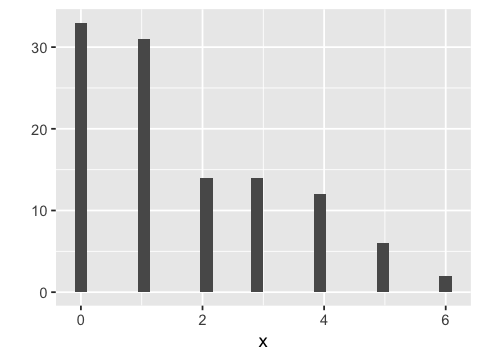

In [25]:
x <- df$count        # наша выборка 
length(x)            # размер выборки 
qplot(x, bins=30)

Судя по гистограмме уместно предположить, что число аварий имеет распределение Пуассона, $Poiss(\lambda)$. Попробуем оценить параметр $\lambda$ методом максимального правдоподобия. 

Вероятность значения: $$ P(X = k) = \frac{e^{-\lambda} \lambda^k}{k!}$$

Логарифмическое правдоподобие: $$ \ln L = \sum x_i \ln \lambda - n \lambda$$

Производная номер один: $$ \frac{\partial \ln L}{\partial \lambda} =  \frac{\sum x_i}{\lambda}  - n $$

Оценка максимального правдоподобия: $$\hat \lambda^{ML} = \bar x$$

А теперь всё то эе самое, но в R!

In [26]:
lnL <- function(lambda, x) {
  n <- length(x)
  answer <- -lambda*n+log(lambda)*sum(x)
  return(answer)
}

In [27]:
# Пара значений функции
lnL(1, x)
lnL(0.5, x)

[1] -112

[1] -188.3911

Кстати говоря, можно было не делать все эти расчёты и вбить функцию правдоподобия вот так: 

In [28]:
lnL_2 <- function(lambda, x) {
  answer <- dpois(x = x, lambda = lambda)
  return(sum(log(answer)))
}

lnL_2(1, x)

[1] -226.8088

Точка на выходе получилась другой, потому что в ручном варианте мы избавились от всех лишних констант. Тут они остались. Если мы будем максимизировать `lnL_2` вместо `lnL`, мы получим тот же результат. Но таскать за собой константы не очень хочется. Иногда они портят процедуру сходимости, поэтому мы будем использовать ручной вариант. __В домашках, в тех местах, где сложно вбить функцию правдоподобия в явном виде (например, гамма-распределение), используйте вариант с `lnL_2`.__  

Давайте посмотрим как выглядит наша функция правдоподобия на картинке. Мы ещё никогда не смотрели на неё на реальной выборке. 

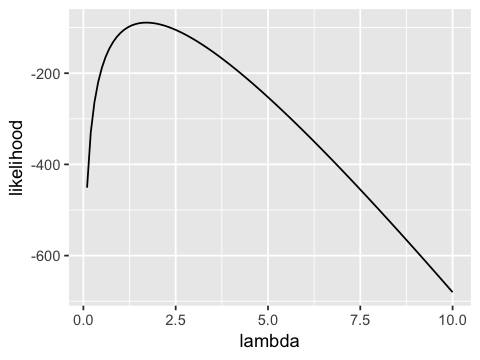

In [29]:
lambda = seq(0.1, 10, 0.1)
likelihood = lnL(lambda, x)
qplot(lambda, likelihood, geom='line')

Ещё давайте посмотрим небольшую гифку с тем, как эта функция правдоподобия накапливается из отдельных наблюдений.

![Гифка](https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2019/gif_creator/animation_likelihood.gif)

Давайте найдём оценку максимального правдоподобия. Пакет позволяет. 

In [30]:
result <- maxLik(lnL, start=2, x=x)
summary(result)

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 4 iterations
Return code 1: gradient close to zero
Log-Likelihood: -89.04906 
1  free parameters
Estimates:
     Estimate Std. error t value Pr(> t)    
[1,]   1.7054     0.1234   13.82  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [31]:
# сверимся с теорией! Оценка получилась хорошей :) 
mean(x)

[1] 1.705357

In [32]:
# Вытащим оценку в отдельную переменную
lambda_hat <- result$estimate

Оценка есть. Теперь хотим доверительный интервал. Сначала построим его вручную, чтобы закрепить теорию. Для этого нам нужна вторая производная :

$$ \frac{\partial^2 \ln L}{\partial \lambda^2} =  -\frac{\sum x_i}{\lambda^2} $$

В этой задачке только один параметр. Поэтому матрица гессе это только одна единственная производная. Давайте найдём оценку дисперсии для нашей $\hat \lambda$: 

$$
- H = \frac{\sum x_i}{\lambda^2}
$$

$$
- E(H) =  \frac{n}{\lambda}
$$

In [33]:
# Первая оценка: 
1/(sum(x)/lambda_hat^2)

[1] 0.0152264

In [34]:
# Вторая оценка: 
1/(length(x)/lambda_hat)

[1] 0.0152264

In [35]:
# Оценка из пакета: 
-1*1/result$hessian

0.01523463


Давайте попробуем воспользоваться этой оценкой. Мы с вами помним, что оценка максимального правдоподобия довольно няшная. Она имеет асимптотически нормальное распределение: 

$$\hat \lambda \sim N(\lambda, 0.015)$$

Давайте построим для неё, отталкиваясь от этой информации доверительный интервал.

In [36]:
alpha = 0.05

z_alpha = qnorm(1 - alpha/2)

se = sqrt(-1*1/result$hessian)

lambda_left  = lambda_hat - z_alpha*se
lambda_right = lambda_hat + z_alpha*se
cat('Параметр lambda с вероятностью 95% лежит между',lambda_left, 'и',lambda_right)

Параметр lambda с вероятностью 95% лежит между 1.463441 и 1.947273

Обратите внимание, что интервал получился довольно коротким. Это сигнализирует о высокой точности оценки. Давайте посмотрим с какой вероятностью в следующем году произойдёт какое количество катастроф, то есть построим прогноз для наших угольных шахт:

In [37]:
f <- 0:5
round(exp(-lambda_hat)*lambda_hat^f/factorial(f),2)

[1] 0.18 0.31 0.26 0.15 0.06 0.02

Вероятнее всего на шахте произойдёт две катастрофы. Надо быть готовым к этому. 

На практике распределение Пуассона часто используют во всемирной организации здравоохрания. У каждого вируса гриппа есть свои особенности и нельзя привить людей сразу от всех недугов. Поэтому с помощью распределения Пуассона пытаются прогнозировать какие разновидности гриппа будут самыми популярными. Вакцину для прививок специфицируют именно под эти разновидности. Ясное дело, что они оценивают на основе распределения Пуассона более сложные модели. Например, Пуассоновскую регрессию. __Если захотите со мной ещё факультативов, поговорим про неё в будущем.__ 

Остался последний нюанс. Выше мы сказали, что если функция плотности $f(x \mid \theta)$ удовлетворяет условиям регулярности, то тогда для любой несмещённой оценки $\hat \theta$ выполняется:

$$
I(\theta) =  E\left( \frac{\partial^2 \ln L}{\partial \theta^2}  \right) = E\left[ \left( \frac{\partial \ln L}{\partial \theta} \right)^2  \right],
$$

то есть вторая производная является ничем иным как информацией Фишера. Давайте убедимся в этом на примере распределения Пуассона. Для простоты будем считать, что у нас есть только одно наблюдение и 

$$\ln L = \ln f(x,\lambda).$$ 

Если мы откроем семинары/лекции или ручками найдём информацию Фишера для распределения Пуассона, мы увидим, что:

$$
J(\lambda) = \frac{1}{\lambda}
$$

Это совпадает с $-E(H)$ для одного наблюдения. __Остановитесь! И задумайтесь о том в чём смысл информации Фишера, при чём тут вторая производная и почему это информация.__ Если вы смогли ответить на эти вопросы, двигайтесь дальше. Если не смогли, то перечитайте начало блокнота. Если вы всё ещё ничего не поняли, пишите в лс :)

# 6. Задача про наркотики, сбор статистики

# 7. Тест отношения правдоподобий

Метод максимального правдоподобия очень распространён. Он используется практически везде. Ещё одноим его полезным своством является то, что с его помощью можно проверять гипотезы. Можно просто брать и смотреть насколько они правдоподобны с точки зрения собранной выборки. 

Давайте посмотрим на ситуацию с шахтами. Нарисуем на картинке функцию правдоподобия, а также точку оптимума. Она будет красной. Кроме неё, нарисуем ещё одну синюю точку. 

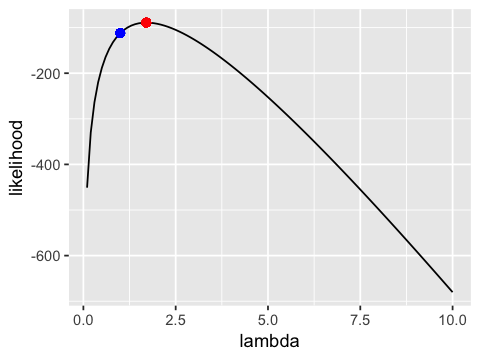

In [38]:
lambda = seq(0.1, 10, 0.1)
likelihood = lnL(lambda, x)

df_L = data.frame(lambda=lambda, likelihood = likelihood)

ggplot(df_L, aes(x=lambda))+
    geom_line(aes(y=likelihood)) +
    geom_point(aes(x=lambda_hat ,y=lnL(lambda_hat, x)), color="red", size=2) +
    geom_point(aes(x=1 ,y=lnL(1, x)), color="blue", size=2) 

По выборке мы получили в качестве оптимума красную точку. Любая оценка, полученная по выборке - случайная величина. А что, если наши данные просто так выпали, что оптимум в красной точке, а на самом деле он в синей, и $\lambda = 1$.

Тест отношения правдоподобий позволяе проверить гипотезы о любых ограничениях на параметры, заданные внутри модели. Нампример, в нашей ситуации гипотеза 

$$
H_0: \lambda = 1
$$

Накладывает ограничение на параметр $\lambda$. Если значение правдоподобия в синей точке не очень сильно отличается от значения в красной точке, мы можем сказать, что данные не противоречат гипотезе и она не отвергается. Осталось только понять как будет распределено расстояние между правдоподобиями. Это же тоже случайные величины.

Оказыватеся, что это расстояние между правдоподобиями распределено как

$$
LR = 2\cdot(\ln L(\hat \theta_{ML}) - \ln L(\theta_0)) \sim \chi^2_q,
$$

где $q$ это количество ограничений. Проверка любой параметрической гипотезы благодаря методу максимального правдоподобия сводится к простому рецепту:

1. Оцениваем модель без ограничений. 
2. Оцениваем модель с ограничением, которое на неё накладывает $H_0$.
3. Смотрим как сильно отличаются правдоподобия. 

Этот рецепт называется __тестом отношения правдоподобий.__ Кстати говоря, этот тест хорош ещё и тем, что в случае простых гипотез, на его основе можно построить критерий максимальной мощности. Про это говорит лемма Неймана-Пирсона, которая была у вас в лекциях. Но о ней мы поговорим в другой раз.  Сейчас давайте попробуем воспользоваться тестом отношения правдоподобий и проверить гипотезу о том, что $\lambda = 1$. 

Найдём наблюдаемое значение статистики:

In [39]:
lambda_0 = 1
LR_obs = 2*(lnL(lambda_hat, x) - lnL(lambda_0, x))
LR_obs

[1] 45.90188

Теперь критическое значение. 

In [40]:
alpha = 0.05
qchisq(1 - alpha/2, df = 1)

[1] 5.023886

Построим для этого добра картинку по аналогии с теми, которые были в тетрадке про гипотезы. 

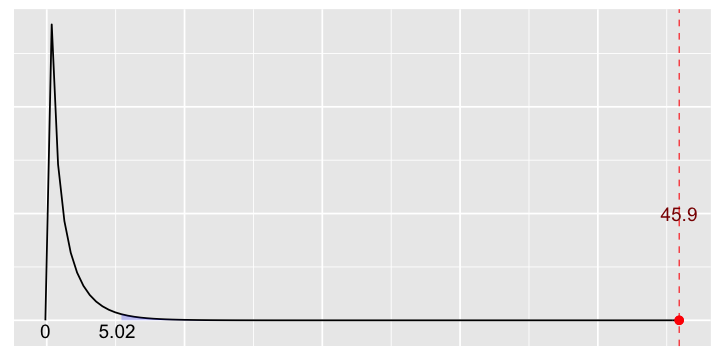

In [41]:
chi_stat_picture(LR_obs, 1)

Наблюдаемое значение статистики попадает глубоко в хвост. Получается, что расстояние между двумя правдоподобиями слишком большое, и гипотеза об ограничении отвергается. 

# 8. Толи нормальные толи равномерные весы 

Решим ещё одну задачку. Пусть Ира раздобыла два золотых слитка массой $m$ каждый (для неё это вообще не проблема, её отец же король, а она принцесса). Также она раздобыла весы, которые работают с погрешностью. 

Сначала Ира положила на весы первый золотой слиток и получила в результате взвешивания $m + \varepsilon_1$, где $ \varepsilon_1$ - случайная величина, ошибка первого взвешивания. Затем Ира положила на весы сразу оба слитка и получил в результате взвешивания $2m + \varepsilon_2$, где $ \varepsilon_2$ - случайная величина, ошибка второго взвешивания. Оказалось, что $y_1 = 60$, $y_2 = 110$.

__a)__ Теперь Ира хочет с помощью метода максимального правдоподобия оценить вес слитка $m$ и погрешность весов $\sigma$, если ошибки не зависят друг от друга и при этом 

$$\varepsilon_i \sim N(0,\sigma^2)$$

__b)__ Ира хочет $80\%$ доверительные интревалы для обоих параметров 

__с)__ Ира хочет проверить гипотезу о том, что $m = 70$ с помощью статистики отношения правдоподобий. 

__d)__ А ещё у Иры есть такая гипотеза:  $\mu = 60$, $\sigma = 15$. 

Для начала осознаем как распределена выборка. 

\begin{equation*}
\begin{aligned}
& y_1 = m + \varepsilon_1 \sim N(m, \sigma^2) \\
& y_2 = 2m + \varepsilon_2 \sim N(2m, \sigma^2)
\end{aligned}
\end{equation*}

Выписываем функцию правдоподобия: 

$$
L = \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot e^{-\frac{(y_1 - m)^2}{2 \sigma^2}} \cdot \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot e^{-\frac{(y_2 - 2m)^2}{2 \sigma^2}}
$$

Прологарифмируем: 

$$
\ln L \propto - \ln \sigma^2 - \frac{(y_1 -m)^2 + (y_2 - 2m)^2}{2 \sigma^2}
$$

Значком $\propto$ обычно обозначают равенство с точностью до константы. Мы, когда выписывали логарифм правдоподобия, избавились от лишних констант, которые никак не влияли на решение задачи. Вбиваем функцию в R. 

In [42]:
y <- c(60, 110)

lnL <- function(th, y){
    return(-log(th[2]) - ((y[1] - th[1])^2 + (y[2] - 2*th[1])^2)/(2*th[2]))
}

# все наши параметры в векторе th
lnL(c(2,2), y)

[1] -3650.693

Находим оптимум:

In [43]:
result <- maxLik(lnL, start=c(2,4), y=y)
summary(result)

Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“созданы NaN”Warning message in log(th[2]):
“

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 21 iterations
Return code 1: gradient close to zero
Log-Likelihood: -3.302585 
2  free parameters
Estimates:
     Estimate Std. error t value Pr(> t)    
[1,]   56.000      1.414  39.600  <2e-16 ***
[2,]   10.000      9.895   1.011   0.312    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

При желании можно свериться с ручными оценками: 

\begin{equation*}
\begin{aligned}
& \hat m = \frac{y_1 + 2 \cdot y_2}{5} \\
& \hat \sigma^2 = \frac{1}{2} \cdot((y_1 - \hat m)^2 + (y_2 - 2 \hat m)^2)
\end{aligned}
\end{equation*}

Давайте построим $80%$ доверительный интервал для $\sigma^2$. 

In [44]:
table <- summary(result)$estimate
table

Estimate,Std. error,t value,Pr(> t)
56.00000,1.414151,39.599740,0.0000000
9.99991,9.894662,1.010637,0.3121903


In [45]:
alpha = 0.2
z_alpha = qnorm(1 - alpha/2)
left = table[2,1] -  z_alpha*table[2,2]
right = table[2,1] +  z_alpha*table[2,2]
cat('Параметр mu с вероятностью 95% лежит между', left, 'и',right, '\n')
cat('Длина интервала:', right - left)

Параметр mu с вероятностью 95% лежит между -2.68061 и 22.68043 
Длина интервала: 25.36104

Теперь проверим гипотезу, что $m = 70$. Для этого будем использовать статистику отношения правдоподобий. Зафиксируем значение $\mu$ и найдём оптимальную оценку для $\sigma$. 

In [50]:
mu0 = 70

lnL_resricted <- function(th, y){
    return(-log(th) - ((y[1] - mu0)^2 + (y[2] - 2*mu0)^2)/(2*th))
}

result_restricted <- maxLik(lnL_resricted, start=4, y=y)
summary(result_restricted)

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 32 iterations
Return code 1: gradient close to zero
Log-Likelihood: -7.214608 
1  free parameters
Estimates:
     Estimate Std. error t value Pr(> t)    
[1,]   500.03      23.73   21.07  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

Теперь можем найти наблюдаемое значение статистики и сравнить его с критическим: 

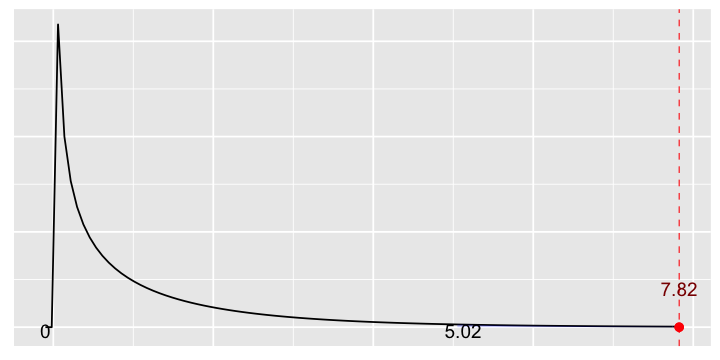

In [55]:
LR_obs = 2*(lnL(result$estimate, y) - lnL_resricted(result_restricted$estimate, y))
chi_stat_picture(LR_obs, 1)

Видим, что гипотеза отвергается. 

Пришло время завершающей гипотезы о том, что одновременно  $\mu = 60$ и $\sigma = 15$. В обычных параметрических критериях мы не обсуждали критерий, который мог бы протестировать сразу же два ограничения. Статистика отношения правдоподобий первый из них. 

In [57]:
mu0 = 60
sigma0 = 70
LR_obs = 2*(lnL(result$estimate, y) - lnL(c(mu0,sigma0), y))

Вспоминаем, что 

$$
LR = 2\cdot(\ln L(\hat \theta_{ML}) - \ln L(\theta_0)) \sim \chi^2_q,
$$

где $q$ это количество ограничений. В нашей гипотезе сразу два ограничения. Поэтому число степеней свободы, $q=2$.  Давайте найдём наблюдаемое значение статистики и критическое. 

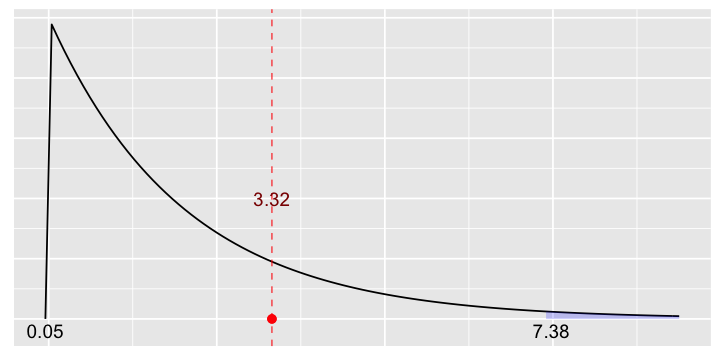

In [58]:
chi_stat_picture(LR_obs, 2)

Гипотеза не отвергается.

## 9. Киллер и тренд во времени.

Помните в первой домашке мы изучали с помощью симуляций игру в Киллера. В послених пунктах домашки мы смотрели, насколько быстро игра протухнет, если интерес к ней падает. На экономе мы играли в киллера дважды. У нас есть немного статистике по игре. Целых два наблюдений. Время между смертями в перой игре и время между смертями во второй игре. Давайте подгрузим их. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


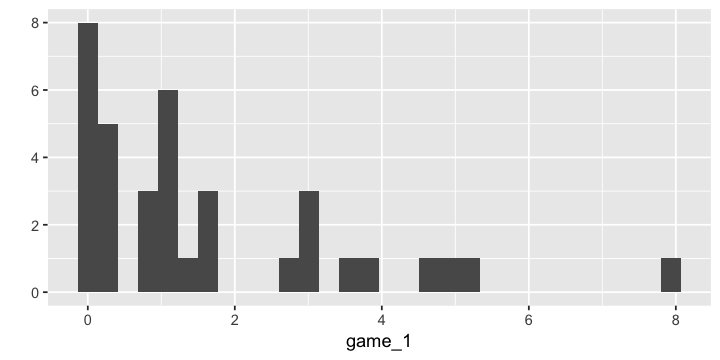

In [59]:
game_1 = read.csv('killer_time1.csv', sep = '\t', dec=',')$hours_between_kill/24
qplot(game_1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


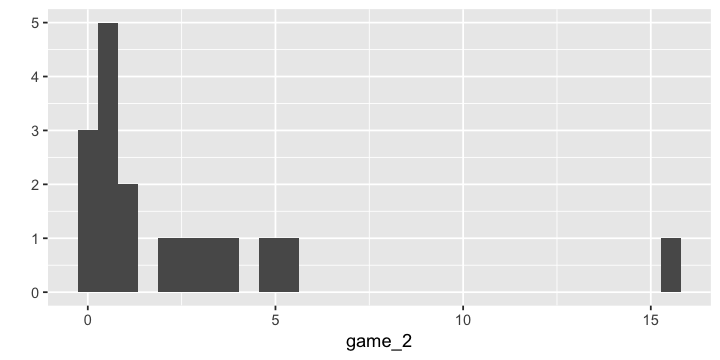

In [60]:
game_2 = read.csv('killer_time2.csv', sep = '\t', dec=',')$hours_between_kill/24
qplot(game_2)

Предположим, что время между смертями имеет экспоненциальное распределение. Судя по гистограммам это похоже на правду. Можно даже гипотезу об этом проверить, при желании. На самом деле время между наступлением событий не всегда распределено экспоненциально. В домашке вы это увидите на примере гейзеров.

Окей, давайте попробуем методом максимального правдоподобия оценить для одной из игр параметр $\alpha$. 

In [61]:
lnL <- function(alpha, x) {
  n <- length(x)
  answer <- -alpha*sum(x)+log(alpha)*n
  return(answer)
}

result <- maxLik(lnL, start=1, x=game_1)
summary(result)

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 6 iterations
Return code 1: gradient close to zero
Log-Likelihood: -53.19531 
1  free parameters
Estimates:
     Estimate Std. error t value  Pr(> t)    
[1,]   0.6202     0.1034       6 1.97e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [62]:
1/mean(game_1)

[1] 0.6202408

Вроде бы совпало. Теперь давайте попробуем усложнить модель. Мы с вами говорили, что протухание в игре должно как-то зависеть от времени, прошедшего с её начала. При симуляциях в первой домашке, мы брали какие-то дискретные моменты времени, и изменяли в них значение $\alpha$. Давайте сделаем умнее. Предположим, что $\alpha$ это функция от времени, прошедшего с начала игры.

Например, предположим, что затухание интереса к игре происходит линейно, то есть 

$$
\alpha = \beta_0 + \beta_1 \cdot t.
$$

В таком случае $X_i \sim Exp(\beta_0 + \beta_1 \cdot t)$, и нам надо оценить параметры $\beta_0$ и $\beta_1$ вместо $\alpha$. Вобьём функцию правдоподобия для такой ситуации. 

In [65]:
betwen_kill = c(game_1, game_2)
time = c(cumsum(game_1), cumsum(game_2))
X = data.frame(time = time,  betwen_kill = betwen_kill)
head(X)

time,betwen_kill
0.249382,0.2493820
1.248449,0.9990668
2.317757,1.0693085
3.821953,1.5041962
3.997485,0.1755315
4.238015,0.2405298


In [66]:
lnL <- function(beta, X) {
  alpha = beta[1] + beta[2]*X$time
  answer = sum(log(dexp(X$betwen_kill, rate = alpha)))
  return(answer)
}

In [67]:
result <- maxLik(lnL, start=c(1, 1), X=X)
summary(result)

Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 11 iterations
Return code 1: gradient close to zero
Log-Likelihood: -79.27675 
2  free parameters
Estimates:
      Estimate Std. error t value  Pr(> t)    
[1,]  0.904094   0.142894   6.327 2.50e-10 ***
[2,] -0.013288   0.003077  -4.319 1.57e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

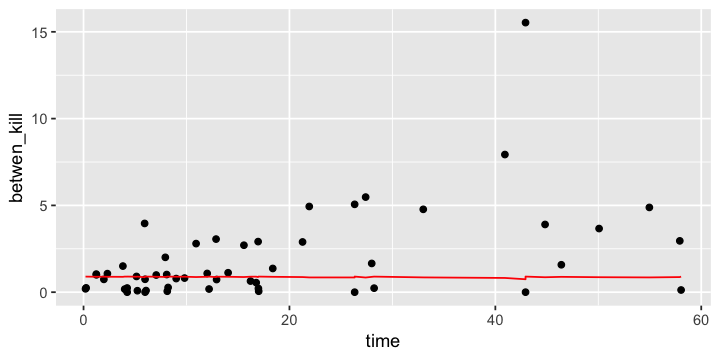

In [69]:
ggplot(X, aes(x=time))+
      geom_point(aes(y=betwen_kill)) + 
      geom_line(aes(y=0.9 - 0.01*betwen_kill), col='red')

Можно попробовать более сложную гипотезу. Например, что 

$$
\alpha = \beta_0 + \beta_1 \cdot e^{\beta_2 \cdot t}
$$

In [70]:
lnL <- function(beta, X) {
  alpha = beta[1] + beta[2]*exp(beta[3]*X$time)
  answer = sum(log(dexp(X$betwen_kill, rate = alpha)))
  return(answer)
}

result <- maxLik(lnL, start=c(1, 1, -2), X=X)
summary(result)

Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы NaN”Warning message in dexp(X$betwen_kill, rate = alpha):
“созданы

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 10 iterations
Return code 1: gradient close to zero
Log-Likelihood: -74.64443 
3  free parameters
Estimates:
     Estimate Std. error t value Pr(> t)   
[1,]  0.20592    0.08887   2.317 0.02050 * 
[2,]  1.69736    0.53791   3.155 0.00160 **
[3,] -0.09203    0.03551  -2.591 0.00956 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

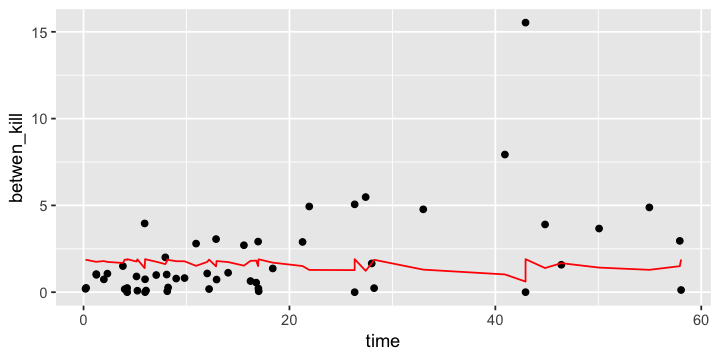

In [71]:
b = result$estimate

ggplot(X, aes(x=time))+
      geom_point(aes(y=betwen_kill)) + 
      geom_line(aes(y=b[1] + b[2]*exp(b[3]*betwen_kill)), col='red')

Давайте посмотрим внимательно на протокол оценивания. Вполне возможно, что трэнд незначим, и на самом деле параметр $\alpha$ никак не зависит от времени, которое длится игра. В протоколе для каждого из коэффициентов трэнда проверяется гипотеза о том, что они равны нулю. Это делается на основе асимптотически нормального распределения, так как метод максимального правдоподобия хорошо дружит с ЦПТ.

In [72]:
summary(result)

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 10 iterations
Return code 1: gradient close to zero
Log-Likelihood: -74.64443 
3  free parameters
Estimates:
     Estimate Std. error t value Pr(> t)   
[1,]  0.20592    0.08887   2.317 0.02050 * 
[2,]  1.69736    0.53791   3.155 0.00160 **
[3,] -0.09203    0.03551  -2.591 0.00956 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

В нашем случае все три коэффициента по отдельности значимы. Тем не менее, они могут оказаться нулевыми по отдельности. Давайте проверим гипотезу об этом тестом максимального правдоподобия. В этот раз $q=3$, так как мы зануляем сразу три коэффициента. 

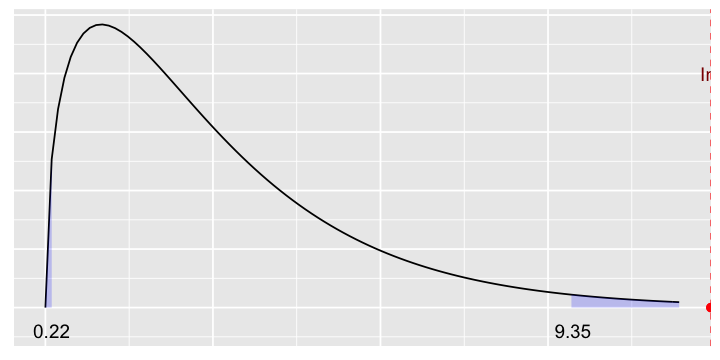

In [76]:
LR_obs = 2*(lnL(b, X) - lnL(c(0,0,0), X))
chi_stat_picture(LR_obs, 3)

Отличная новость! Гипотеза отвергается. Это означает, что при симуляции игры в Киллера мы можем попробовать использовать оценённую нами модель. 

# Что мы сегодня осознали? 

* Метод максимального правдоподобия - что я вижу, то и есть на самом деле.  
* Производные содержут в себе информацию и именно они используются для её передачи в современной статистике и машинном обучении. Например, вторая производная функции правдоподобия говорит о том, насколько ярко выражен пик правдоподобия. 
* Информация Фишера говорит о острие пика, это усреднённая по выборке вторая производная, взятая со знаком минус (потому что мы максимизируем правдоподобие, в оптимуме вторая производная отрицательна, надо это компенсировать ещё одним минусом).
